# Predicting US House Prices

This project leverages a dataset of 2.2 million USA real estate listings, containing details about the houses to predict their prices. A linear regression model is used and iterated up to increase the accuracy of its predictions.

## 1. Load, Preview and Clean Data

In [31]:
#Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [32]:
path = "/Users/amanserhan/predicting_house_prices/realtor-data.zip.csv"
data = pd.read_csv(path)
data.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB


In [34]:
# Converting some of the numerical columns from floats to integers
new_dtypes = {
    "brokered_by" : "Int64",
    "bed" : "Int64",
    "bath" : "Int64",
    "street" : "Int64",
    "zip_code" : "Int64",
}
data = data.astype(new_dtypes)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     Int64  
 1   status          object 
 2   price           float64
 3   bed             Int64  
 4   bath            Int64  
 5   acre_lot        float64
 6   street          Int64  
 7   city            object 
 8   state           object 
 9   zip_code        Int64  
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: Int64(5), float64(3), object(4)
memory usage: 214.4+ MB


In [35]:
data.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,2221849.0,2.224841e+06,1745065.0,1714611.0,1.900793e+06,2215516.0,2226083.0,1.657898e+06
mean,52939.893287,5.241955e+05,3.275841,2.49644,1.522303e+01,1012324.920665,52186.676341,2.714471e+03
std,30642.752884,2.138893e+06,1.567274,1.652573,7.628238e+02,583763.478326,28954.084538,8.081635e+05
min,0.0,0.000000e+00,1.0,1.0,0.000000e+00,0.0,0.0,4.000000e+00
25%,23861.0,1.650000e+05,3.0,2.0,1.500000e-01,506312.75,29617.0,1.300000e+03
50%,52884.0,3.250000e+05,3.0,2.0,2.600000e-01,1012765.5,48382.0,1.760000e+03
75%,79183.0,5.500000e+05,4.0,3.0,9.800000e-01,1521173.25,78070.0,2.413000e+03
max,110142.0,2.147484e+09,473.0,830.0,1.000000e+05,2001357.0,99999.0,1.040400e+09


## 2. Analysis and Modelling

   Looking at the summary of the central tendency, dispersion, and shape of a dataset’s distribution in the previous code cell, we can already spot some interesting findings. For example, the average price of a house is 524,195, but the standard deviation is 2,138,893, including a pretty high dispersion level in the data. The 75th percentile is pretty close to the mean, at 550,000. That observation coupled with the high maximum price of 2,147,484,000 suggests that there are a few high data points pulling the mean upwards. 
   Similarly, for our bed, bath, and house size columns, the mean falls between the 50th and 75th percent, with very high values for our maximum value. This suggests that it might be worthwhile to look at how many entries have such high numbers, and if removing the outliers is necessary for more accurate analysis. Interestingly, this trend is even more pronounced for the size of the lot, where the mean is 2 orders of magnitude higher than the 75th percentile, and the maximum value is 6 orders of magnitude higher than the 75th percentile. 
   With the price as the dependent variable, let's first plot some graphs and see what correlations we can observe between price and some of these columns.

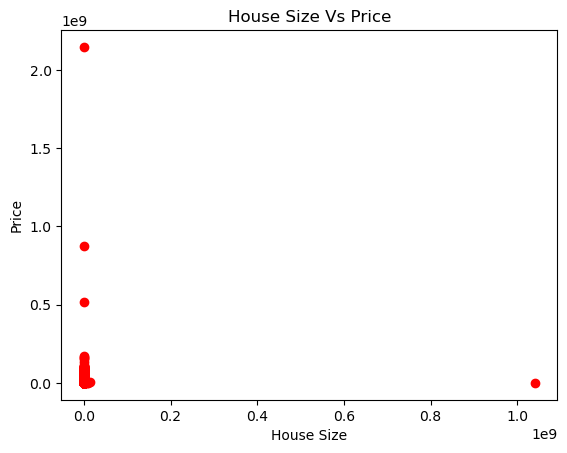

In [38]:
# House Size vs Price
fig1, ax1 = plt.subplots()
ax1.scatter(data['house_size'], data['price'], color='r')
ax1.set_title('House Size Vs Price')
ax1.set_xlabel('House Size')
ax1.set_ylabel('Price')
plt.show()

The few outlier points are preventing us from properly seeing trends in that data, so let's handle them using the interquartile range outlier rule.

In [40]:
columns = ["price", "bed", "bath", "acre_lot", "house_size"]
for col in columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determining outlier bounds using the 1.5*IQR outlier rule
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Boolean mask for the non-outliers:
    mask = (data[col] >= lower_bound) & (
        data[col] <= upper_bound
    )
    
    # New column setting outlier values to NaN
    data.loc[~mask, col] = np.nan
    data = data.dropna(subset=[col])

data.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378,for_sale,105000.0,3,2,0.12,1962661,Adjuntas,Puerto Rico,601,920.0,NaN
1,52707,for_sale,80000.0,4,2,0.08,1902874,Adjuntas,Puerto Rico,601,1527.0,NaN
2,103379,for_sale,67000.0,2,1,0.15,1404990,Juana Diaz,Puerto Rico,795,748.0,NaN
3,31239,for_sale,145000.0,4,2,0.10,1947675,Ponce,Puerto Rico,731,1800.0,NaN
5,103378,for_sale,179000.0,4,3,0.46,1850806,San Sebastian,Puerto Rico,612,2520.0,NaN


Let's first call describe() again and observe any changes to our descriptive statistics, then go back to visualizing.

In [42]:
data.describe()

,brokered_by,price,bed,bath,acre_lot,street,zip_code,house_size
count,970773.0,9.723710e+05,972371.0,972371.0,972371.000000,969623.0,972324.0,972371.000000
mean,53915.575437,3.781817e+05,3.208877,2.280873,0.219206,929388.330249,55437.07254,1783.793186
std,30223.30795,2.173390e+05,0.764711,0.792443,0.151848,532472.079065,28783.596206,621.394163
min,0.0,1.000000e+00,2.0,1.0,0.000000,63.0,601.0,100.000000
25%,25983.0,2.200000e+05,3.0,2.0,0.130000,464883.5,30906.0,1309.000000
50%,53016.0,3.390000e+05,3.0,2.0,0.180000,934532.0,55426.0,1685.000000
75%,79221.0,4.950000e+05,4.0,3.0,0.270000,1389725.5,80226.0,2171.000000
max,110142.0,1.127000e+06,5.0,4.0,0.830000,2001321.0,99929.0,3572.000000


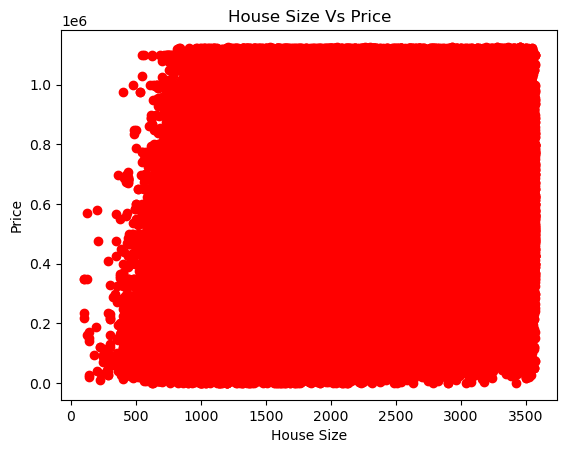

In [43]:
# House Size vs Price
fig1, ax1 = plt.subplots()
ax1.scatter(data['house_size'], data['price'], color='r')
ax1.set_title('House Size Vs Price')
ax1.set_xlabel('House Size')
ax1.set_ylabel('Price')
plt.show()

As we can see, our dataset is too big for us to plot all the points and glean insights, so let's plot a smaller, random sample instead.

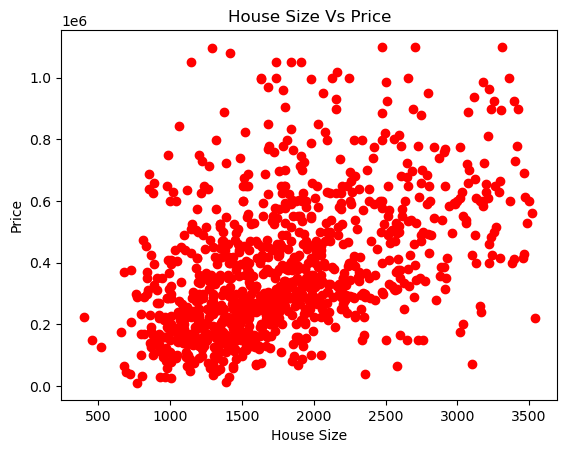

In [45]:
sample = data.sample(n=1000, random_state=42)
# House Size vs Price
fig1, ax1 = plt.subplots()
ax1.scatter(sample['house_size'], sample['price'], color='r')
ax1.set_title('House Size Vs Price')
ax1.set_xlabel('House Size')
ax1.set_ylabel('Price')
plt.show()

Much better. We can see a positive correlation between the house size and the price, so let's start there with a linear regression model.

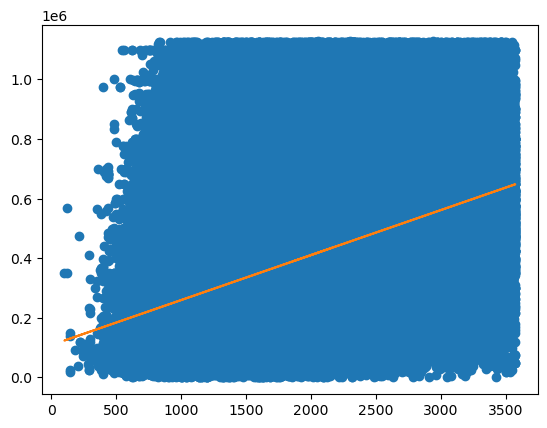

In [47]:
X = data[['house_size']] 
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

line = model.predict(X_train)
plt.plot(X_train,y_train,"o")
plt.plot(X_train,line,linestyle = "solid")
plt.show()

Let's evaluate the model by calculating the coefficient of determination and the root mean squared error

In [48]:
r_squared = model.score(X_test, y_test)
print(f'R-squared: {r_squared:.2f}')

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

R-squared: 0.18
Root Mean Squared Error: 196083.02


Our coefficient of determination is relatively low, but to correctly asses our mean squared error, let's take a look at the standard deviation and range of the price column to assess if around $200,000 is a reasonable prediction error.

In [50]:
std_ = data['price'].std()
print ('Standard Deviation: ', std_)
range_ = data['price'].max() - data['price'].min()
print ("Range: ", range_)

Standard Deviation:  217339.00252935747
Range:  1126999.0


With a standard deviation of 217,339 and a range of 1,126,999, a mean squared error of 196,083 isn't too bad, but let's see if adding more features will improve our predictions, starting with beds and baths.

In [52]:
#Multiple Linear Regression model
X_m = data[['house_size','bed','bath']] 
y_m = data['price']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

model_m = LinearRegression()
model_m.fit(X_train_m, y_train_m)

LinearRegression()

In [53]:
# Let's evaluate the model by calculating the coefficient of determination and the root mean squared error
r_squared_m = model_m.score(X_test_m, y_test_m)
print(f'R-squared: {r_squared_m:.2f}')

y_pred_m = model_m.predict(X_test_m)

mse_m = mean_squared_error(y_test_m, y_pred_m)
rmse_m = np.sqrt(mse_m)
print(f'Root Mean Squared Error: {rmse_m:.2f}')

R-squared: 0.22
Root Mean Squared Error: 191634.33


Our coefficient of determination increased a bit, and the RMSE dropped around 2%. These are not significant changes, which tells us that the number of beds and baths in the house are not super helpeful for improving the accuracy of our model. Next steps for this project could be testing the impact of some of the other possible features on the accuracy of the model. Or trying our other types of models beyond linear regression.